In [1]:
#Install necessary libraries
!pip install -U gradio langchain langchain-community pypdf langchain-google-genai langgraph --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8

In [2]:
#import necessary modules and setup environment

from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
from langchain.document_loaders import PyPDFLoader
from langchain.chains.summarize import load_summarize_chain
import gradio as gr

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
      model="gemini-1.5-flash",
      temperature=0,
      max_tokens=None,
      timeout=None,
      max_retries=2
)

In [5]:
#Summarizes the content of a PDF file using the map_reduce chain.

def summarize_pdf(pdf_file_path):

    loader = PyPDFLoader(pdf_file_path)
    docs = loader.load_and_split()
    chain = load_summarize_chain(llm, chain_type="map_reduce")
    summary = chain.invoke(docs)

    return summary['output_text']

In [6]:
summary = summarize_pdf("/content/joy.pdf")

In [8]:
summary# map_reduce

'A registration clerk, Mitya Kuldarov, celebrates his newfound, albeit embarrassing, national fame after a newspaper article details his drunken fall under a horse-drawn sledge.\n'

### Summarization using the refine chain

   This section demonstrates how to summarize a PDF using the refine chain, which iteratively improves the summary with each document chunk.

In [9]:
def summarize_pdf(pdf_file_path):
    loader = PyPDFLoader(pdf_file_path)
    docs = loader.load_and_split()
    chain = load_summarize_chain(llm, chain_type="refine")
    summary = chain.invoke(docs)

    return summary['output_text']

In [11]:
summary     #refine

'A registration clerk, Mitya Kuldarov, celebrates his newfound, albeit embarrassing, national fame after a newspaper article details his drunken fall under a horse-drawn sledge.\n'

**Iterative Refinement Implementation**

In [15]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

In [12]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

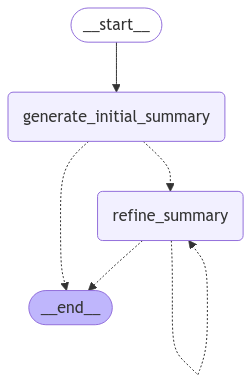

In [13]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [16]:

async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

Apples can be red.

Apples can be red, and blueberries are blue.

Apples are red, blueberries are blue, and bananas are yellow.



**Map Reduce Implementation**

In [17]:
!pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.3 MB/s eta 0:00:00


In [18]:
from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [19]:
#load document

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Generated 14 documents.


In [20]:
# Map Step

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("human", "Write a concise summary of the following:\\n\\n{context}")]
)

map_chain = map_prompt | llm | StrOutputParser()

In [21]:
# Reduce Step

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain = reduce_prompt | llm | StrOutputParser()

In [22]:
!pip install -qU langgraph

In [23]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

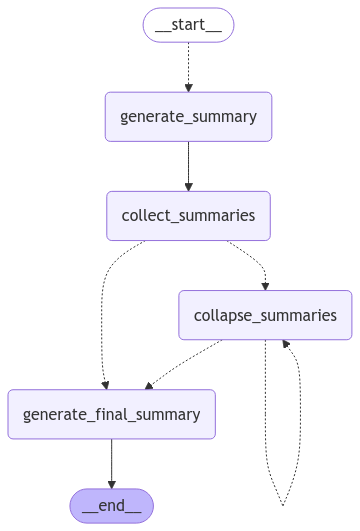

In [24]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [ ]:
# Invoke graph
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))